In [14]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Data Handling and Processing
import numpy as np
import pandas as pd
import math
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import viztoolz as viz
import mltoolz as mlt
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Selection, Metrics & Evaluation
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE, SelectPercentile, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Pipeline Construction 
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Handling
from joblib import dump, load
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

---
---
## Load train and prediction set

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

print('-'*16)
print(f'Train Set Shape:\n{train.shape}')
print('-'*16)
print(f'Test Set Shape:\n{test.shape}')
print('-'*16)

----------------
Train Set Shape:
(8693, 14)
----------------
Test Set Shape:
(4277, 13)
----------------


---
---
## Define functions for:
- cross-validation of the training set using balanced accuracy, F1 and ROC-AUC scores
- evaluating model against validation set with options to:
    - print a full classification report
    - display a confusion matrix

In [3]:
def cv_evaluate(model, X, y, print_scores=False):
    
    scoring = ['balanced_accuracy','f1','roc_auc']
    results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)

    balanced_acc = np.mean(results['test_balanced_accuracy'])
    f1_score = np.mean(results['test_f1'])
    roc_auc = np.mean(results['test_roc_auc'])
    if print_scores:
        print(f'Mean Cross Validation Scores for {model.__class__.__name__}:\n{"-"*21}')
        print(f'Balanced accuracy: {balanced_acc:.5f}')
        print(f'F1: {f1_score:.5f}')
        print(f'ROC_AUC: {roc_auc:.5f}') 
    return balanced_acc, f1_score, roc_auc

def fit_test_evaluate(model, X_train, y_train, X_test, y_test, scores=False, class_report=False, confusion_mat=False):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    roc_auc = roc_auc_score(y_test, y_preds)
    if scores:
        print(f'Test Scores:\n{"-"*12}')
        print(f'Accuracy Score: {accuracy:.5f}')
        print(f'F1 score: {f1:.5f}\n')
        print(f'ROC-AUC score: {roc_auc:.5f}\n')
    

    if class_report:
        print(f'Classification Report:\n{"-"*22}')
        print(classification_report(y_test, y_preds))

    if confusion_mat:
        print(f'Confusion Matrix:\n{"-"*17}')
        ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
    return None

---
---
## Define custom classes to handle data processing

In [4]:
# Transform PassengerId into InGroup and GroupSize
class TransformPassengerId(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['GroupId'] = X['PassengerId'].str.split('_').str[0]
        X['PassengerNumber'] = X['PassengerId'].str.split('_').str[1].astype(float)
        group_counts = X['GroupId'].value_counts()
        X['GroupSize'] = X['GroupId'].map(group_counts)
        X['InGroup'] = np.where(X['GroupSize'] > 1, 1, 0)
        return X


# Transform Cabin into Deck, CabinPosition and Side 
class TransformCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['Deck'] = X['Cabin'].str.split('/').str[0]
        X['CabinNumber'] = X['Cabin'].str.split('/').str[1].astype(float)
        X['Side'] = X['Cabin'].str.split('/').str[2]
        bin_edges = np.linspace(X['CabinNumber'].min(), X['CabinNumber'].max(), 5)
        X['CabinPosition'] = pd.cut(X['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)
        return X


# Impute HomePlanet
class ImputeHomePlanet(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        group_modes = X.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = group_modes[X['HomePlanet'].isna()]

        deck_modes = X.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = deck_modes[X['HomePlanet'].isna()]

        if 'VIP' in X.columns:
            vip_mode_homePlanet = X.loc[X['VIP'] == True, 'HomePlanet'].mode().iloc[0]
            X.loc[X['VIP'] & X['HomePlanet'].isna(), 'HomePlanet'] = vip_mode_homePlanet

        X['HomePlanet'].fillna(X['HomePlanet'].mode().iloc[0], inplace=True)

        return X


# Create proportional imputer and impute
class ProportionalImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        impute_cols = ['Destination', 'Deck', 'Side', 'CabinPosition', 'VIP', 'CryoSleep']
        for col in impute_cols:
            proportions = X.groupby('HomePlanet')[col].value_counts(normalize=True)

            def impute_values(row):
                if pd.isna(row[col]):
                    group = row['HomePlanet']
                    if pd.notna(group) and group in proportions.index:
                        group_proportions = proportions.loc[group].dropna()
                        return np.random.choice(group_proportions.index, p=group_proportions.values)
                return row[col]
        
            X[col] = X.apply(impute_values, axis=1)
        return X


# KNN Imputer and transformer
class KNNImputerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        self.imputer = KNNImputer(n_neighbors=5)
        self.imputer.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.columns] = self.imputer.transform(X[self.columns])
        return X


# Create TotalSpent column
class CreateTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['TotalSpent'] = X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
        return X


# Convert binary classes to int 
class ToInt(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        cols = ['InGroup', 'CryoSleep', 'VIP', 'Transported']
        for col in cols:
            if col in X.columns:
                X[col] = X[col].astype(int)
        return X


# Drop unwanted columns
class DropColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        droppers = ['PassengerNumber', 'GroupId', 'Cabin', 'CabinNumber', 'Name']
        X.drop(columns=droppers, inplace=True, errors='ignore')
        return X

---
---
## Split train into X, y pairs and train, validation sets

In [5]:
target = 'Transported'

train = shuffle(train, random_state=42)
train, val = train_test_split(train, test_size=0.3, stratify=train[target], random_state=42)

X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

---
---
## Instantiate base algorithms

Set up column lists for processing in pipeline

In [6]:
ohe_cols = ['HomePlanet','Destination','Deck','Side','CabinPosition','InGroup','VIP','CryoSleep','GroupSize']
scaler_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent']

Base algorithms

In [7]:
lr = LogisticRegression(C=1, max_iter=1000)
svc = SVC(C=1, kernel='sigmoid', gamma='scale')

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)
xgbm = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
catb = CatBoostClassifier(iterations=100, depth=5, cat_features=ohe_cols, l2_leaf_reg=2)

base_algs = {'lr':lr, 'svc':svc, 'rf':rf, 'lgbm':lgbm, 'xgbm':xgbm, 'catb':catb}

---
---
## Build base pipeline

***NOTE***:  
- A pipeline is probably more complicated that is necessary for this particular puzzle.
- However the use of a pipeline provides the best workflow to avoid data leakage from the training folds into the validation folds during cross validation.

In [15]:
preprocess = Pipeline([
    ('TransformPassengerId', TransformPassengerId()),
    ('TransformCabin', TransformCabin()),
    ('ImputeHomePlanet', ImputeHomePlanet()),
    ('ProportionalImputer', ProportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', CreateTotalSpent()),
    ('ToInt', ToInt()),
    ('DropColumns', DropColumns())
])

scaling = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

manipulator = ColumnTransformer(force_int_remainder_cols=False,
        transformers=[
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
                ('transformScale', scaling, scaler_cols)],
                remainder = 'passthrough')

feature_selection = RFE(estimator=RandomForestClassifier(random_state=42, n_estimators=100), n_features_to_select=8)
feature_select_percentile = SelectPercentile(mutual_info_classif, percentile=50)

pipe = Pipeline([
    ('process', preprocess),
    ('mainpulate', manipulator),
    ('select_features', feature_selection),
    ('clf', base_algs['rf'])
])

Check pipeline works with

In [9]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('process',
                 Pipeline(steps=[('TransformPassengerId',
                                  TransformPassengerId()),
                                 ('TransformCabin', TransformCabin()),
                                 ('ImputeHomePlanet', ImputeHomePlanet()),
                                 ('ProportionalImputer', ProportionalImputer()),
                                 ('KNNImputer', KNNImputerTransformer()),
                                 ('CreateTotalSpent', CreateTotalSpent()),
                                 ('ToInt', ToInt()),
                                 ('DropColumns', DropColumns())])),
                ('mainp...
                                                   'VIP', 'CryoSleep',
                                                   'GroupSize']),
                                                 ('transformScale',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpent'])])),
                ('select_features',
                 RFE(estimator=RandomForestClassifier(random_state=42),
                     n_features_to_select=8)),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [10]:
mlt.cv_evaluate(pipe, X_train, y_train, scoring=['balanced_accuracy','f1','roc_auc'], print_scores=True)

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.79344
Test_f1: 0.80325
Test_roc_auc: 0.85027



{'test_balanced_accuracy': 0.7934412238151314,
 'test_f1': 0.8032536727229601,
 'test_roc_auc': 0.850266575197433}

adding RFE makes the model perform worse

---
---
## Cross Validation with feature selection

I am going to trial 2 built in feature selection methods in scikit-learn:
- select percentile (50% of features)  
- Recursive feature selection (n_features = 5, 8)

---
## Cross validate all base algorithms on test data with RFE feature selection

***Feature Selection***:
- estimator = RandomForestClassifier()
- n_features = 8

***Metrics***:
- Balanced accuracy
- F1 score
- ROC-AUC

In [ ]:
models = []
balanced_accs = []
f1_scores = []
roc_auc_scores = []
pipelines = {}

for name, alg in base_algs.items():
    if name != 'catb':
        pipe = Pipeline([
            ('process', preprocess),
            ('mainpulate', manipulator),
            ('select features', feature_selection),
            ('clf', alg)
        ])

        pipelines[name] = pipe

        results = mlt.cv_evaluate(pipe, X_train, y_train, scoring=['balanced_accuracy','f1','roc_auc'], print_scores=False)

        models.append(alg.__class__.__name__)
        balanced_accs.append(results['test_balanced_accuracy'])
        f1_scores.append(results['test_f1'])
        roc_auc_scores.append(results['test_roc_auc'])

cross_val_df = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

cross_val_df

---
## Cross validate all base algorithms on test data with select_percentile feature selection

***Feature Selection***:
- percentile = 50%

***Metrics***:
- Balanced accuracy
- F1 score
- ROC-AUC

In [17]:
models_sel_percentile = []
balanced_accs_sel_percentile = []
f1_scores_sel_percentile = []
roc_auc_scores_sel_percentile = []
pipelines_sel_percentile = {}

for name, alg in base_algs.items():
    if name != 'catb':
        pipe = Pipeline([
            ('process', preprocess),
            ('mainpulate', manipulator),
            ('select features', feature_select_percentile),
            ('clf', alg)
        ])

        pipelines_sel_percentile[name] = pipe

        results = mlt.cv_evaluate(pipe, X_train, y_train, scoring=['balanced_accuracy','f1','roc_auc'], print_scores=False)

        models_sel_percentile.append(alg.__class__.__name__)
        balanced_accs_sel_percentile.append(results['test_balanced_accuracy'])
        f1_scores_sel_percentile.append(results['test_f1'])
        roc_auc_scores_sel_percentile.append(results['test_roc_auc'])

cross_val_df_sel_percentile = pd.DataFrame({
    'Model': models_sel_percentile,
    'Balanced Accuracy': balanced_accs_sel_percentile,
    'F1 Score': f1_scores_sel_percentile,
    'ROC-AUC': roc_auc_scores_sel_percentile
})

cross_val_df_sel_percentile

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.75190
Test_f1: 0.75161
Test_roc_auc: 0.82716

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.50338
Test_f1: 0.50439
Test_roc_auc: 0.50647

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.80087
Test_f1: 0.80516
Test_roc_auc: 0.88516

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.79886
Test_f1: 0.80436
Test_roc_auc: 0.89186

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.79566
Test_f1: 0.79853
Test_roc_auc: 0.88491



,Model,Balanced Accuracy,F1 Score,ROC-AUC
0,LogisticRegression,0.751896,0.751605,0.827163
1,SVC,0.503378,0.504394,0.506465
2,RandomForestClassifier,0.800872,0.805160,0.885164
3,LGBMClassifier,0.798856,0.804356,0.891857
4,XGBClassifier,0.795661,0.798532,0.884906


---
## Cross validate all base algorithms on test data without feature selection

***Metrics***:
- Balanced accuracy
- F1 score
- ROC-AUC

In [12]:
models_nofs = []
balanced_accs_nofs = []
f1_scores_nofs = []
roc_auc_scores_nofs = []
pipelines_nofs = {}

for name, alg in base_algs.items():
    if name != 'catb':
        pipe = Pipeline([
            ('process', preprocess),
            ('mainpulate', manipulator),
            ('clf', alg)
        ])

        pipelines_nofs[name] = pipe

        results = mlt.cv_evaluate(pipe, X_train, y_train, scoring=['balanced_accuracy','f1','roc_auc'], print_scores=False)

        models_nofs.append(alg.__class__.__name__)
        balanced_accs_nofs.append(results['test_balanced_accuracy'])
        f1_scores_nofs.append(results['test_f1'])
        roc_auc_scores_nofs.append(results['test_roc_auc'])

cross_val_df_nofs = pd.DataFrame({
    'Model': models_nofs,
    'Balanced Accuracy': balanced_accs_nofs,
    'F1 Score': f1_scores_nofs,
    'ROC-AUC': roc_auc_scores_nofs
})

cross_val_df_nofs

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.75386
Test_f1: 0.75381
Test_roc_auc: 0.83222

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.50207
Test_f1: 0.50275
Test_roc_auc: 0.50579

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.80185
Test_f1: 0.80190
Test_roc_auc: 0.88860

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.80369
Test_f1: 0.80721
Test_roc_auc: 0.89929

Mean Cross Validation Scores for Pipeline:
------------------------------
Test_balanced_accuracy: 0.79882
Test_f1: 0.80083
Test_roc_auc: 0.89585



,Model,Balanced Accuracy,F1 Score,ROC-AUC
0,LogisticRegression,0.753861,0.753811,0.832223
1,SVC,0.502068,0.502747,0.505785
2,RandomForestClassifier,0.801845,0.801898,0.888602
3,LGBMClassifier,0.803691,0.807208,0.899289
4,XGBClassifier,0.798819,0.800827,0.895854


---
---
## Hyperparameter Tuning

In [23]:
gs_best_estimators = {}
gs_best_scores = {}

rs_best_estimators = {}
rs_best_scores = {}

---
### Random Forest

Hyperparameter Tuning with GridSearchCV

In [20]:
params_grid_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}
gs = GridSearchCV(estimator=pipelines['rf'], param_grid=params_grid_rf, cv=5, n_jobs=1, scoring='accuracy')

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('process',
                                        Pipeline(steps=[('TransformPassengerId',
                                                         TransformPassengerId()),
                                                        ('TransformCabin',
                                                         TransformCabin()),
                                                        ('ImputeHomePlanet',
                                                         ImputeHomePlanet()),
                                                        ('ProportionalImputer',
                                                         ProportionalImputer()),
                                                        ('KNNImputer',
                                                         KNNImputerTransformer()),
                                                        ('CreateTotalSpent',
                                                         CreateTotalSpent()),
                                                        ('ToInt', ToInt()),
                                                        ('DropColumn...
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck',
                                                                          'TotalSpent'])])),
                                       ('clf',
                                        RandomForestClassifier(max_depth=10,
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'clf__max_depth': [None, 10, 20, 30],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [24]:
rf_gs_tuned = gs.best_estimator_
gs_best_estimators['rf'] = rf_gs_tuned
gs_best_scores['rf'] = gs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

Best Hyperparameters:
{'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}

Best Accuracy Score:
0.8078882497945769


Hyperparameter Tuning with RamdomizedSearchCV

In [27]:
params_rand_rf = {
    'clf__n_estimators': np.arange(50,501,10),
    'clf__max_depth': [None] + list(np.arange(5, 51, 5)),
    'clf__min_samples_split': [2, 5, 10, 15],
    'clf__min_samples_leaf': [1, 2, 4, 8],
    'clf__bootstrap': [True, False]
}

rs = RandomizedSearchCV(estimator=pipelines['rf'], param_distributions=params_rand_rf, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

In [30]:
rs.fit(X_train, y_train)
rf_rs_tuned = rs.best_estimator_
rs_best_estimators['rf'] = rf_rs_tuned
rs_best_scores['rf'] = rs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters:
{'clf__max_depth': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}

Best Accuracy Score:
0.8078882497945769


---
### LGBM

Hyperparameter Tuning with GridSearchCV

In [32]:
params_grid_lgbm = {
    'clf__num_leaves': [31, 50, 70],
    'clf__max_depth': [-1, 10, 20, 30],
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__n_estimators': [100, 200, 300]
}

gs = GridSearchCV(estimator=pipelines['lgbm'], param_grid=params_grid_lgbm, cv=5, n_jobs=1, scoring='accuracy')
gs.fit(X_train, y_train)

lgbm_gs_tuned = gs.best_estimator_
gs_best_estimators['lgbm'] = lgbm_gs_tuned
gs_best_scores['lgbm'] = gs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters:
{'clf__learning_rate': 0.01, 'clf__max_depth': 10, 'clf__n_estimators': 300, 'clf__num_leaves': 31}

Best Accuracy Score:
0.8105176663927691


Hyperparameter Tuning with RamdomizedSearchCV

In [39]:
params_rand_lgbm = {
    'clf__num_leaves': [20, 31, 40, 50, 70, 100],
    'clf__max_depth': [-1, 5, 10, 20, 30, 50],
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__n_estimators': [int(x) for x in range(50, 500, 50)],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

rs = RandomizedSearchCV(estimator=pipelines['lgbm'], param_distributions=params_rand_lgbm, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
rs.fit(X_train, y_train)

lgbm_rs_tuned = rs.best_estimator_
rs_best_estimators['LGBM'] = lgbm_rs_tuned
rs_best_scores['LGBM'] = rs.best_score_

print(f'Best Hyperparameters:\n{rs.best_params_}')
print()
print(f'Best Accuracy Score:\n{rs.best_score_}')

Best Hyperparameters:
{'clf__subsample': 0.8, 'clf__num_leaves': 20, 'clf__n_estimators': 450, 'clf__max_depth': 10, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 1.0}

Best Accuracy Score:
0.8088742810188989


---
### XGBM

Hyperparameter tuning with GridSearchCV

In [41]:
params_grid_xgbm = {
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.1, 0.01, 0.001],
    'clf__n_estimators': [100, 200, 300],
    'clf__subsample': [0.6, 0.8, 1.0]
}

gs = GridSearchCV(estimator=pipelines['xgbm'], param_grid=params_grid_xgbm, cv=5, n_jobs=1, scoring='accuracy')
gs.fit(X_train, y_train)

xgbm_gs_tuned = gs.best_estimator_
gs_best_estimators['xgbm'] = xgbm_gs_tuned
gs_best_scores['xgbm'] = gs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

Best Hyperparameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 0.8}

Best Accuracy Score:
0.8105176663927691


Hyperparameter tuning with RandomizedSearchCV

In [44]:
params_rand_xgbm = {
    'clf__max_depth': [int(x) for x in range(3, 15, 2)],
    'clf__learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'clf__n_estimators': [int(x) for x in range(50, 500, 50)],
    'clf__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 0.1, 0.3, 0.5]
}

rs = RandomizedSearchCV(estimator=pipelines['xgbm'], param_distributions=params_rand_xgbm, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
rs.fit(X_train, y_train)

xgbm_rs_tuned = rs.best_estimator_
rs_best_estimators['xgbm'] = xgbm_rs_tuned
rs_best_scores['xgbm'] = rs.best_score_

print(f'Best Hyperparameters:\n{rs.best_params_}')
print()
print(f'Best Accuracy Score:\n{rs.best_score_}')

Best Hyperparameters:
{'clf__subsample': 0.7, 'clf__n_estimators': 300, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__gamma': 0, 'clf__colsample_bytree': 1.0}

Best Accuracy Score:
0.810024650780608


---
### Logistic Regression

Hyperparameter tuning with GridSearchCV  

Needed to define 3 separate grids due to incompatability of certain parameters

In [61]:
param_grids = [
    {
        'clf__solver': ['saga'],
        'clf__penalty': ['elasticnet'],
        'clf__C': [0.1, 0.5, 1.0, 2.0],
        'clf__l1_ratio': [0.1, 0.4, 0.6, 0.9],  # Only for elasticnet
        'clf__max_iter': [1000, 5000, 10000]
    },
    {
        'clf__solver': ['liblinear'],
        'clf__penalty': ['l1', 'l2'],  # Only l1 and l2  by liblinear solver
        'clf__C': [0.1, 0.5, 1.0, 2.0],
        'clf__max_iter': [1000, 5000, 10000]
    },
    {
        'clf__solver': ['lbfgs'],
        'clf__penalty': ['l2'],
        'clf__C': [0.1, 0.5, 1.0, 2.0],
        'clf__max_iter': [1000, 5000, 10000]
    }
]

gs = GridSearchCV(estimator=pipelines['lr'], param_grid=param_grids, cv=5, n_jobs=1, scoring='accuracy')
gs.fit(X_train, y_train)

lr_gs_tuned = gs.best_estimator_
gs_best_estimators['lr'] = lr_gs_tuned
gs_best_scores['lr'] = gs.best_score_

print(f'Best Hyperparameters:\n{gs.best_params_}')
print()
print(f'Best Accuracy Score:\n{gs.best_score_}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters:
{'clf__C': 0.1, 'clf__max_iter': 10000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

Best Accuracy Score:
0.7554642563681184


In [64]:
dump(gs_best_estimators['rf'], './models/rf_tuned.joblib')
dump(rs_best_estimators['rf'], './models/rf_RStuned.joblib')
dump(gs_best_estimators['lgbm'], './models/lgbm_tuned.joblib')
dump(rs_best_estimators['LGBM'], './models/lgbm_RStuned.joblib')
dump(gs_best_estimators['xgbm'], './models/xgbm_tuned.joblib')
dump(rs_best_estimators['xgbm'], './models/xgbm_RStuned.joblib')
dump(gs_best_estimators['lr'], './models/lr_tuned.joblib')

['./models/lr_tuned.joblib']

---
## What about a stacking model?

could also try the final estimator as a voting classifier

In [65]:
sc = StackingClassifier(
    estimators = [
        ('rf_tuned', gs_best_estimators['rf']),
        ('lgbm_tuned', gs_best_estimators['lgbm'])],
        final_estimator = gs_best_estimators['xgbm'])

In [ ]:
sc = StackingClassifier(
    estimators = [
        ('rf_tuned', 'rf'),
        ('lgbm_tuned', 'lgbm')],
        final_estimator = 'xgbm')

In [66]:
mlt.cv_evaluate(pipe, X_train, y_train, scoring=['balanced_accuracy','f1','roc_auc'], print_scores=False)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_stacking.py", line 672, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_stacking.py", line 288, in fit
    _fit_single_estimator(self.final_estimator_, X_meta, y, fit_params=fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_base.py", line 40, in _fit_single_estimator
    estimator.fit(X, y, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py", line 533, in fit_transform
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/50/1z4vl3_96lj7wvqp_4kxvlm80000gn/T/ipykernel_15648/1889873467.py", line 8, in transform
    X['GroupId'] = X['PassengerId'].str.split('_').str[0]
                   ~^^^^^^^^^^^^^^^
IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


---
---
## Evaluation of tuned models with validation set

Random Forest

Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.78      0.80      0.79      1295
        True       0.80      0.77      0.79      1313

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608

Confusion Matrix:
-----------------


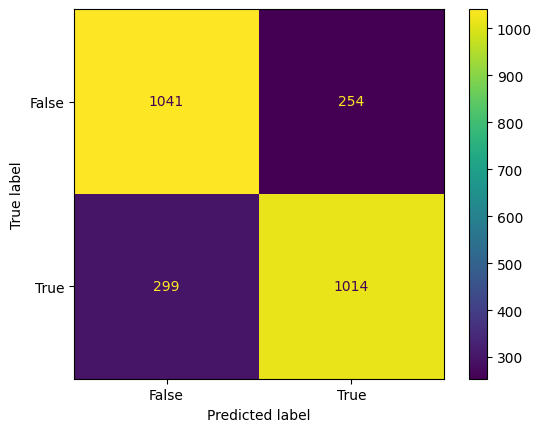

In [55]:
fit_test_evaluate(gs_best_estimators['rf'], X_train, y_train, X_val, y_val, class_report=True, confusion_mat=True)

---
LGBM

Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.80      0.77      0.79      1295
        True       0.78      0.81      0.80      1313

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608

Confusion Matrix:
-----------------


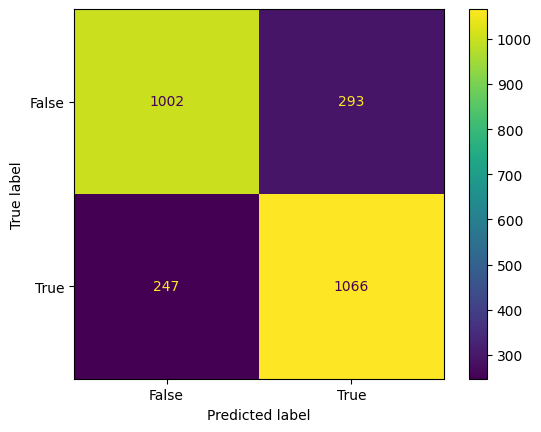

In [50]:
fit_test_evaluate(gs_best_estimators['lgbm'], X_train, y_train, X_val, y_val, class_report=True, confusion_mat=True)

---
XGBM

Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.80      0.76      0.78      1295
        True       0.77      0.82      0.80      1313

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608

Confusion Matrix:
-----------------


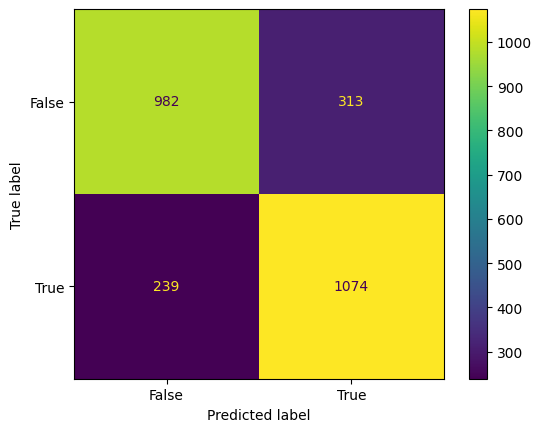

In [51]:
fit_test_evaluate(gs_best_estimators['xgbm'], X_train, y_train, X_val, y_val, class_report=True, confusion_mat=True)

---
Logistic Regression

In [ ]:
fit_test_evaluate(gs_best_estimators['lr'], X_train, y_train, X_val, y_val, class_report=True, confusion_mat=True)

Not quite hitting the 80% accuracy goal. Close but no cigar. maybe use best one and submit on prediction set to see how it turns out when the whole prediction set is used

---
## K-Nearest Neighbors with Gower Distance

How could i incorporate this into the pipeline of models??

In [ ]:
import gower
from sklearn.neighbors import KNeighborsClassifier

gower_dist = gower.gower_matrix(X_train)

knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
knn.fit(gower_dist, y_train)

---
## Feature selection ideas

In [ ]:
from sklearn.feature_selection import RFE
feature_selection = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)